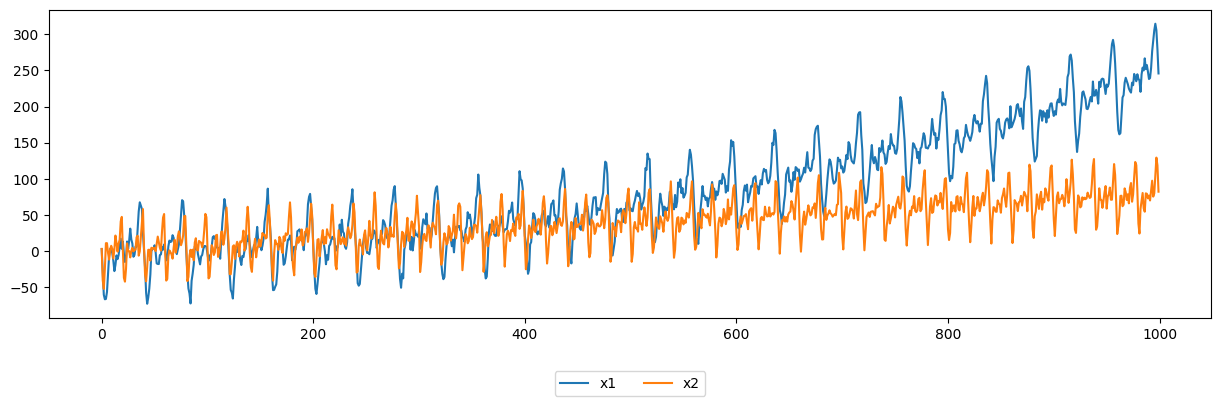

In [2]:
# -*- coding: utf-8 -*-
"""
Building Seq2Seq LSTM with Luong Attention in Keras for Time Series Forecasting

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb
"""

import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
!pip install pydot
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
#keras.utils.vis_utils.pydot = pyd

## create some time series data
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

800
[ 2.39733371e-04  1.07079105e-02 -2.35355365e+00]
[ 0.08010925 -0.55978432]


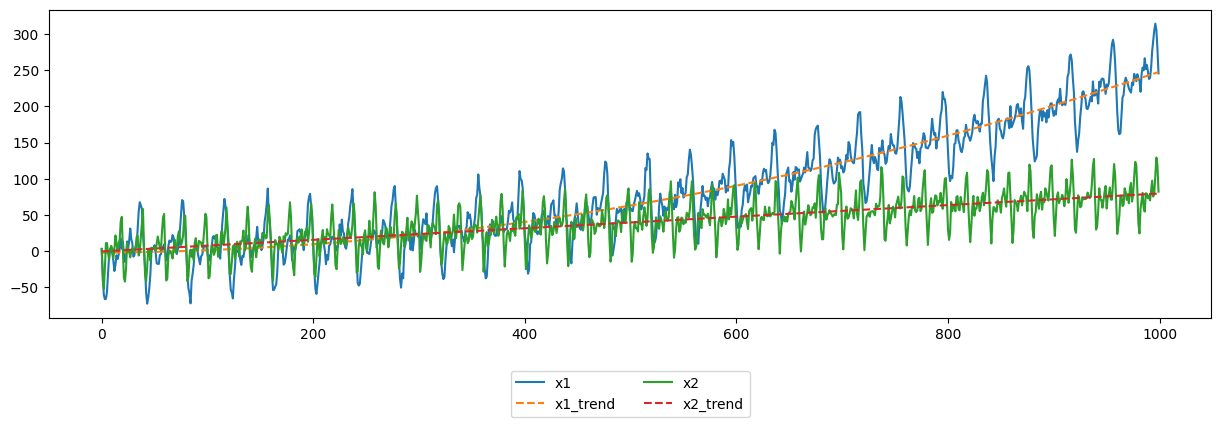

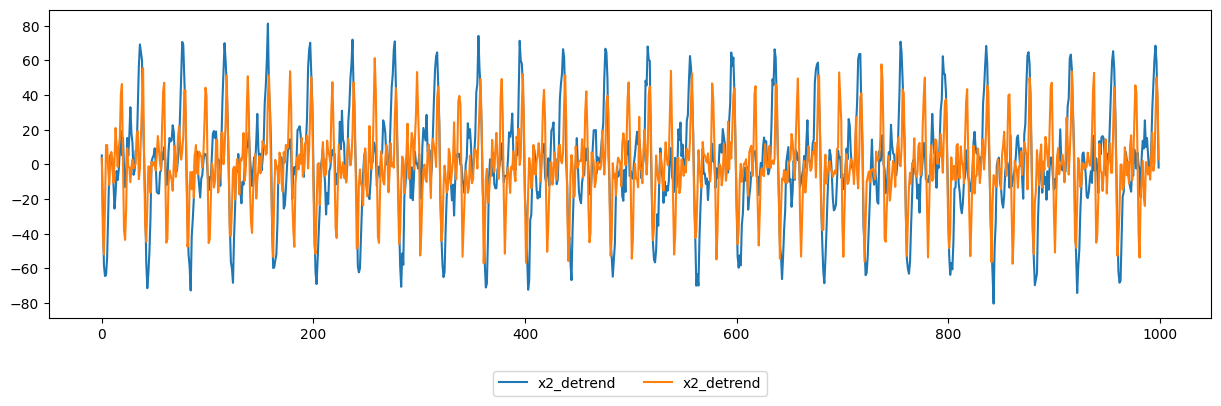

(1000, 4)
[[  5.18358542   3.57924542   0.           1.        ]
 [-25.70980837 -40.05821031   1.           1.        ]
 [-58.05573225 -51.89893261   2.           1.        ]
 ...
 [ 58.98226178  50.03506987 997.           0.        ]
 [ 31.93339432  39.18127001 998.           0.        ]
 [ -1.79339883   2.73846564 999.           0.        ]]
[81.17391620115193, 61.24556732577484, 1, 1]
[[ 6.38577718e-02  5.84408893e-02  0.00000000e+00  1.00000000e+00]
 [-3.16724997e-01 -6.54058931e-01  1.00000000e+00  1.00000000e+00]
 [-7.15201816e-01 -8.47390838e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 7.26615944e-01  8.16958223e-01  9.97000000e+02  0.00000000e+00]
 [ 3.93394773e-01  6.39740502e-01  9.98000000e+02  0.00000000e+00]
 [-2.20932895e-02  4.47128790e-02  9.99000000e+02  0.00000000e+00]]


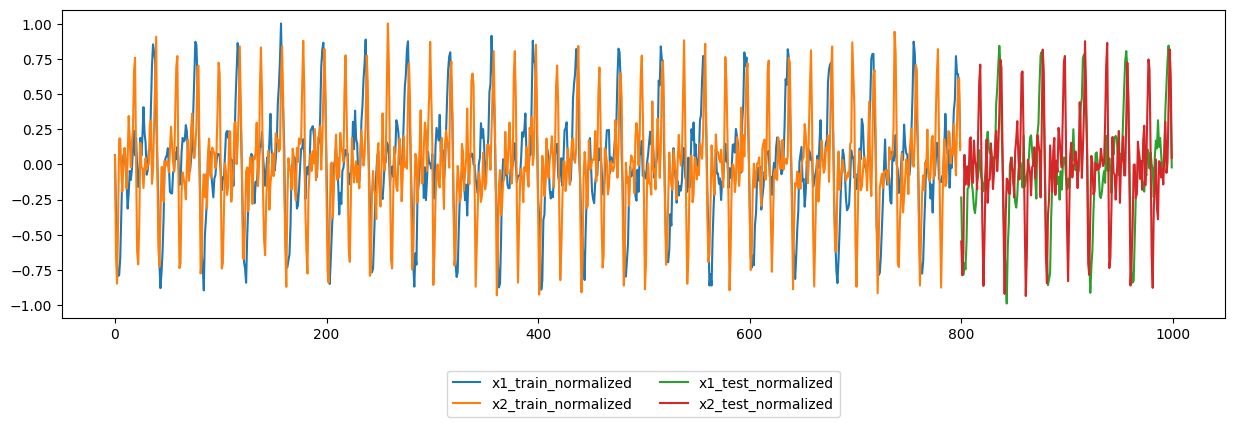

(781, 200, 3) (781, 20, 3) (781,)
(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [3]:
##--------------------##
##---- Preprocess ----##
##--------------------##

# 1. Split sequences to 80% train set and 20% test set
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

# 2. Detrending to make nonstationary TS to be nonstationary 
# Create index number of each position in the sequence
x_index = np.array(range(len(t)))  

# np.polyfit을 사용하여 주어진 데이터에 대해 다항회귀곡선를 적합하여 회귀계수를 반환
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)
#[ 2.54288143e-04 -7.91042877e-04 -9.43349334e-01]
#[ 0.08240923 -1.59840828]

# 회귀계수를 사용하여 x1, x2에 대한 추세선을 만들고 해당 그림을 그린다 
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# 추세를 제거한다
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# 3. Combine sequences
# label 1 for train set and label 0 for test set
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)  #(1000, 4)
print(x_lbl)
"""
[[  1.82328904  -1.22422275   0.           1.        ]
 [-26.40252621 -33.19321429   1.           1.        ]
 [-58.08735822 -48.78109449   2.           1.        ]
 ...
 [ 48.3343013   45.84367454 997.           0.        ]
 [ 17.84053813  38.48640568 998.           0.        ]
 [ -9.21047255  -7.84378736 999.           0.        ]]
"""

# 4. Normalize training and test sets
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)
#[74.62766534979171, 57.9005279317233, 1, 1]

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# 5. Truncate
# Cut sequence into smaller pieces by sliding an input window (length = 200 time steps) 
# and an output window (length = 20 time steps), and put these samples in 3d numpy arrays
# The function truncate generates 3 arrays.

def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)
#(781, 200, 3) (781, 20, 3) (781,)

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)
#(600, 200, 3) (600, 20, 3)
#(181, 200, 3) (181, 20, 3)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshap

C:\Users\sangwoo\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


5/5 [==============================] - 22s 3s/step - loss: 3.6683 - mae: 0.9718 - val_loss: 0.1299 - val_mae: 0.2628
Epoch 2/100
5/5 [==============================] - 17s 3s/step - loss: 0.1838 - mae: 0.3258 - val_loss: 0.1305 - val_mae: 0.2649
Epoch 3/100
5/5 [==============================] - 15s 3s/step - loss: 0.1345 - mae: 0.2726 - val_loss: 0.1253 - val_mae: 0.2597
Epoch 4/100
5/5 [==============================] - 15s 3s/step - loss: 0.1221 - mae: 0.2571 - val_loss: 0.1167 - val_mae: 0.2503
Epoch 5/100
5/5 [==============================] - 15s 3s/step - loss: 0.1150 - mae: 0.2487 - val_loss: 0.1095 - val_mae: 0.2411
Epoch 6/100
5/5 [==============================] - 17s 3s/step - loss: 0.1112 - mae: 0.2447 - val_loss: 0.1062 - val_mae: 0.2393
Epoch 7/100
5/5 [==============================] - 15s 4s/step - loss: 0.1065 - mae: 0.2409 - val_loss: 0.1030 - val_mae: 0.2363
Epoch 8/100
5/5 [==============================] - 15s 3s/step - loss: 0.1047 - mae: 0.2398 - val_loss: 0.099

5/5 [==============================] - 5s 936ms/step - loss: 0.0253 - mae: 0.1178 - val_loss: 0.0213 - val_mae: 0.1081
Epoch 64/100
5/5 [==============================] - 4s 844ms/step - loss: 0.0246 - mae: 0.1169 - val_loss: 0.0217 - val_mae: 0.1107
Epoch 65/100
5/5 [==============================] - 4s 878ms/step - loss: 0.0251 - mae: 0.1179 - val_loss: 0.0218 - val_mae: 0.1079
Epoch 66/100
5/5 [==============================] - 4s 892ms/step - loss: 0.0247 - mae: 0.1168 - val_loss: 0.0213 - val_mae: 0.1105
Epoch 67/100
5/5 [==============================] - 5s 924ms/step - loss: 0.0234 - mae: 0.1143 - val_loss: 0.0150 - val_mae: 0.0947
Epoch 68/100
5/5 [==============================] - 4s 896ms/step - loss: 0.0242 - mae: 0.1159 - val_loss: 0.0162 - val_mae: 0.0973
Epoch 69/100
5/5 [==============================] - 4s 891ms/step - loss: 0.0219 - mae: 0.1111 - val_loss: 0.0143 - val_mae: 0.0936
Epoch 70/100
5/5 [==============================] - 4s 898ms/step - loss: 0.0200 - mae: 0

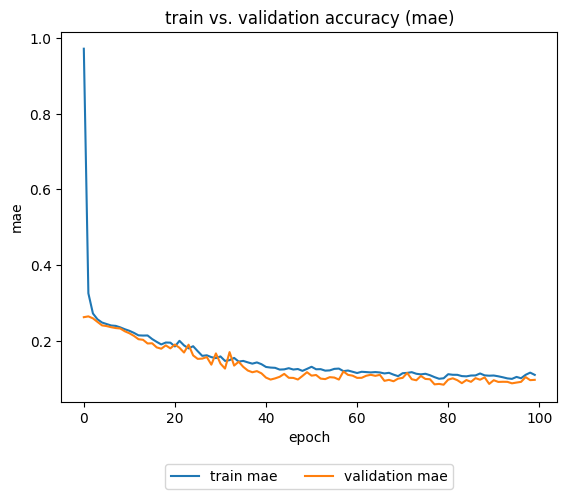

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)
(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)
train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


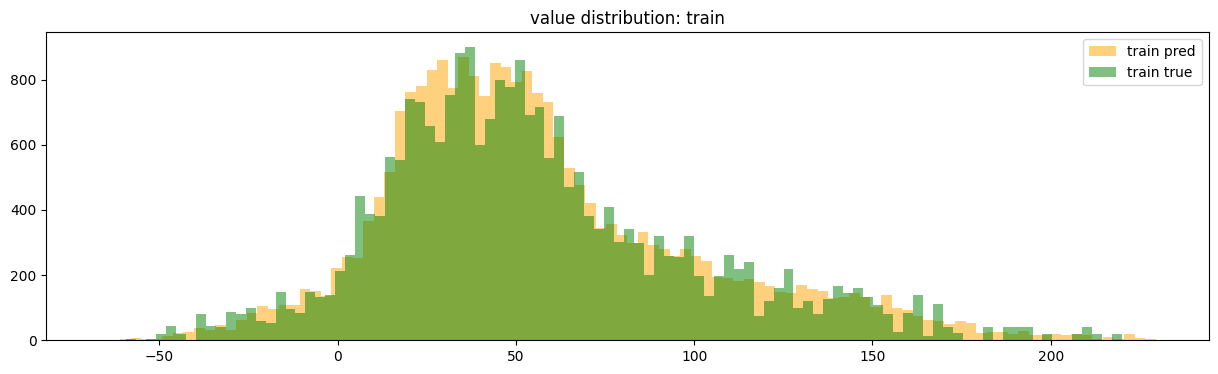

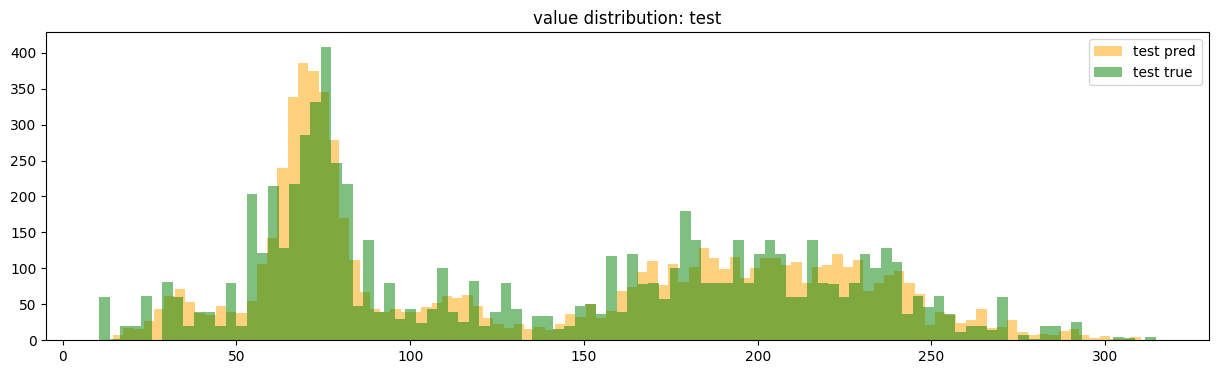

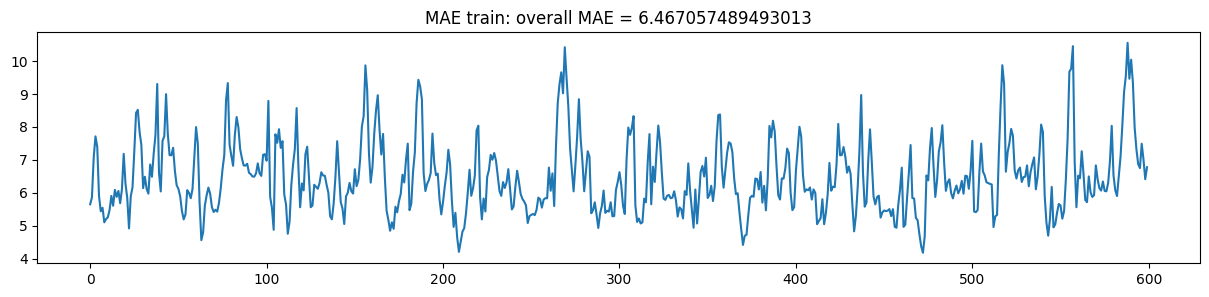

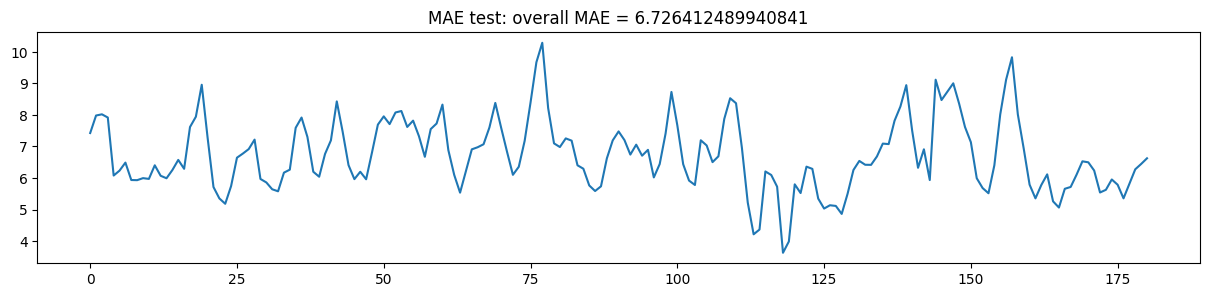

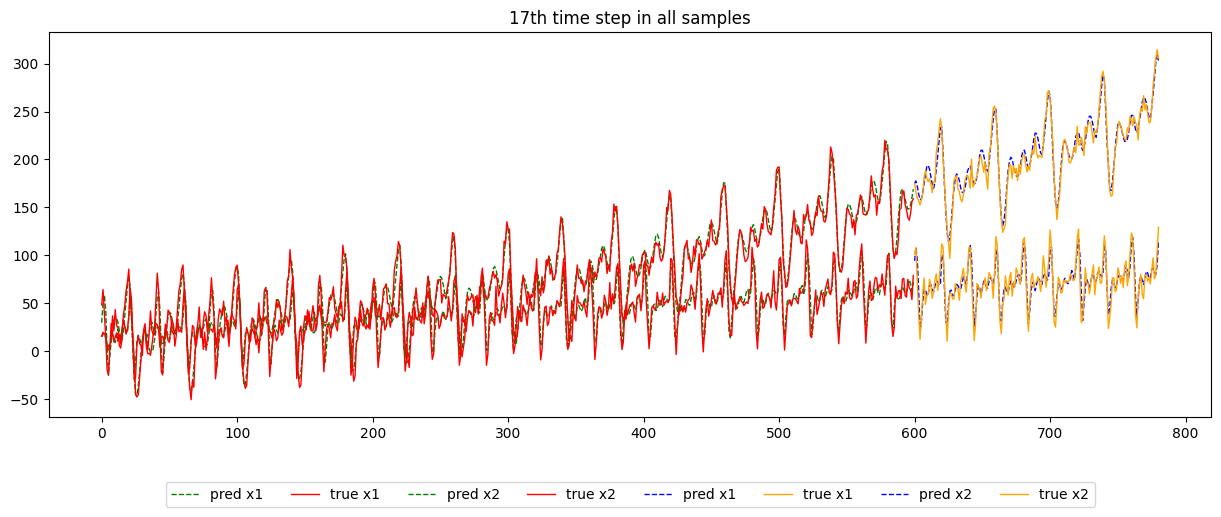

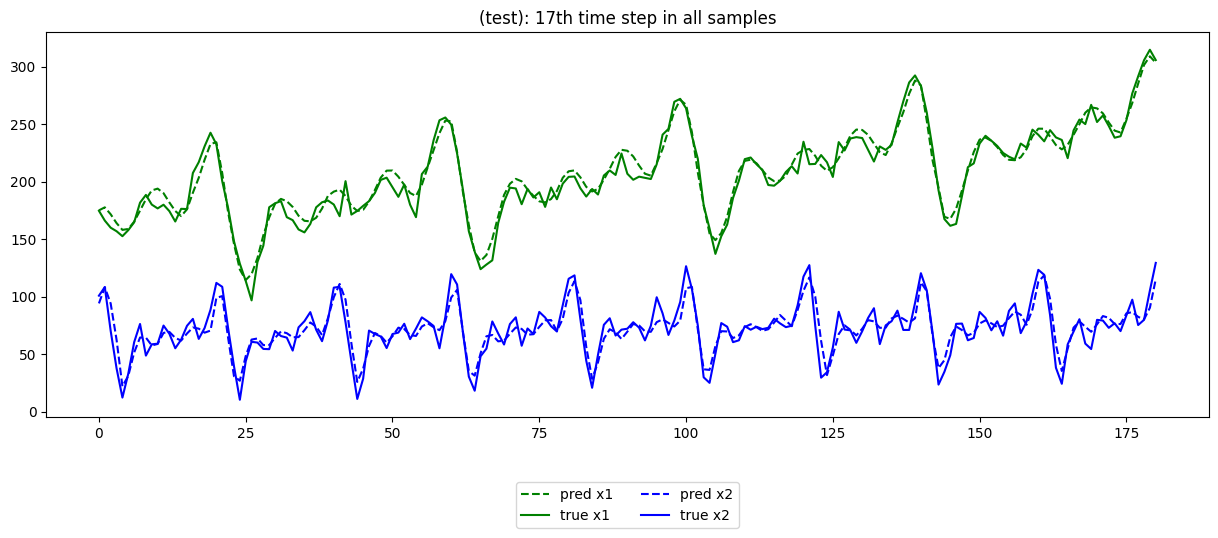

In [4]:
##--------------------------------------------##
##---- Model 1: Simple LSTM Seq2Seq Model ----##
##--------------------------------------------##

# Set number of hidden neurons
n_hidden = 100

#---- The input layer
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)
#Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
#Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)

#---- The encoder LSTM: we only need last state_h and last state_c
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
  n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
  return_sequences=False, return_state=True)(input_train)
#return_state=True => Last Hidden State+ Last Hidden State (again!) + Last Cell State 

print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)
#KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
#KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
#KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")

# Add batch normalisation to avoid gradient explosion
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

#---- The decoder LSTM: we make 20 copies of the last hidden state of encoder & 
# use them as input to the decoder
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)
#KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)
#KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")

# Build the model and compile it
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

# Plot the model: 
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Train the model
epoch = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epoch, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#---- Prediction:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
#(600, 20, 2) (181, 20, 2)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)
#(600, 20, 2) (181, 20, 2)

# Combine the unnormalised outputs with their corresponding index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
#(600, 20, 3) (181, 20, 3)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
#(600, 20, 3) (181, 20, 3)

# put all the outputs with recovered trend into a dictionary data_final
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))
#train_pred: (600, 20, 2)
#train_true: (600, 20, 2)
#test_pred: (181, 20, 2)
#test_true: (181, 20, 2)

# Check if the prediction value distribution is reasonable
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()
#The data distribution of prediction and true values are almost overlapped, so we are good.

# plot MAE of all samples in time order
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()
#We can say that there are still certain periodical pattens in both train and test MAE. 
#Training for more epochs may lead to better results.    
    
# check the nth prediction of each time step:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

# Take a closer look at the prediction on test set:    
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()    

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.flo

C:\Users\sangwoo\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


5/5 [==============================] - 7s 915ms/step - loss: 0.1382 - mae: 0.2746 - val_loss: 0.1276 - val_mae: 0.2587
Epoch 2/100
5/5 [==============================] - 4s 861ms/step - loss: 0.1239 - mae: 0.2543 - val_loss: 0.1186 - val_mae: 0.2523
Epoch 3/100
5/5 [==============================] - 4s 880ms/step - loss: 0.1183 - mae: 0.2520 - val_loss: 0.1217 - val_mae: 0.2585
Epoch 4/100
5/5 [==============================] - 4s 862ms/step - loss: 0.1122 - mae: 0.2457 - val_loss: 0.1033 - val_mae: 0.2396
Epoch 5/100
5/5 [==============================] - 4s 887ms/step - loss: 0.1027 - mae: 0.2389 - val_loss: 0.1029 - val_mae: 0.2414
Epoch 6/100
5/5 [==============================] - 4s 869ms/step - loss: 0.1033 - mae: 0.2381 - val_loss: 0.1041 - val_mae: 0.2495
Epoch 7/100
5/5 [==============================] - 4s 855ms/step - loss: 0.1010 - mae: 0.2454 - val_loss: 0.1003 - val_mae: 0.2440
Epoch 8/100
5/5 [==============================] - 4s 860ms/step - loss: 0.0970 - mae: 0.2378 -

5/5 [==============================] - 5s 921ms/step - loss: 0.0152 - mae: 0.0949 - val_loss: 0.0128 - val_mae: 0.0880
Epoch 64/100
5/5 [==============================] - 5s 937ms/step - loss: 0.0149 - mae: 0.0941 - val_loss: 0.0105 - val_mae: 0.0804
Epoch 65/100
5/5 [==============================] - 4s 882ms/step - loss: 0.0149 - mae: 0.0938 - val_loss: 0.0123 - val_mae: 0.0873
Epoch 66/100
5/5 [==============================] - 4s 904ms/step - loss: 0.0147 - mae: 0.0933 - val_loss: 0.0125 - val_mae: 0.0888
Epoch 67/100
5/5 [==============================] - 5s 945ms/step - loss: 0.0157 - mae: 0.0957 - val_loss: 0.0143 - val_mae: 0.0941
Epoch 68/100
5/5 [==============================] - 5s 974ms/step - loss: 0.0146 - mae: 0.0928 - val_loss: 0.0110 - val_mae: 0.0815
Epoch 69/100
5/5 [==============================] - 5s 1000ms/step - loss: 0.0146 - mae: 0.0932 - val_loss: 0.0102 - val_mae: 0.0784
Epoch 70/100
5/5 [==============================] - 5s 899ms/step - loss: 0.0139 - mae: 

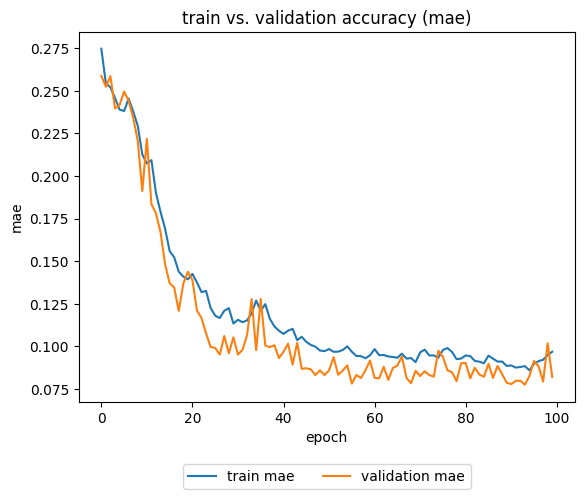

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)
(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)
train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


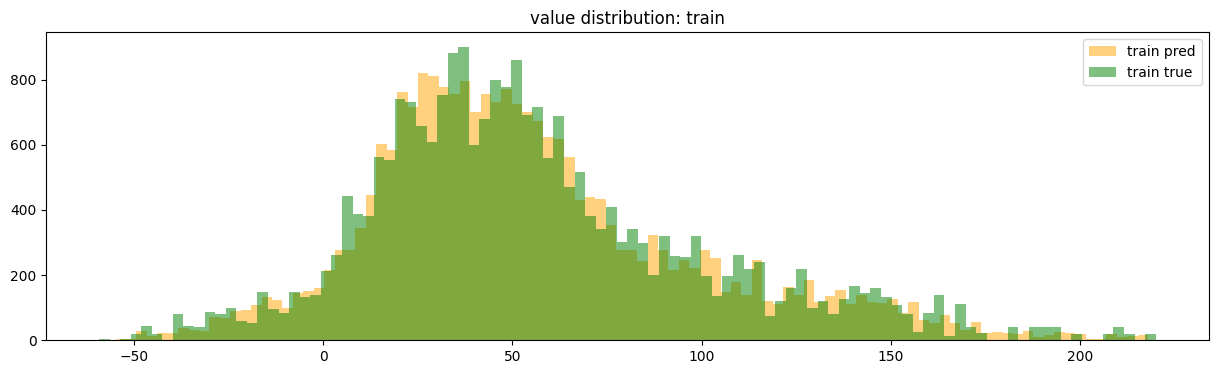

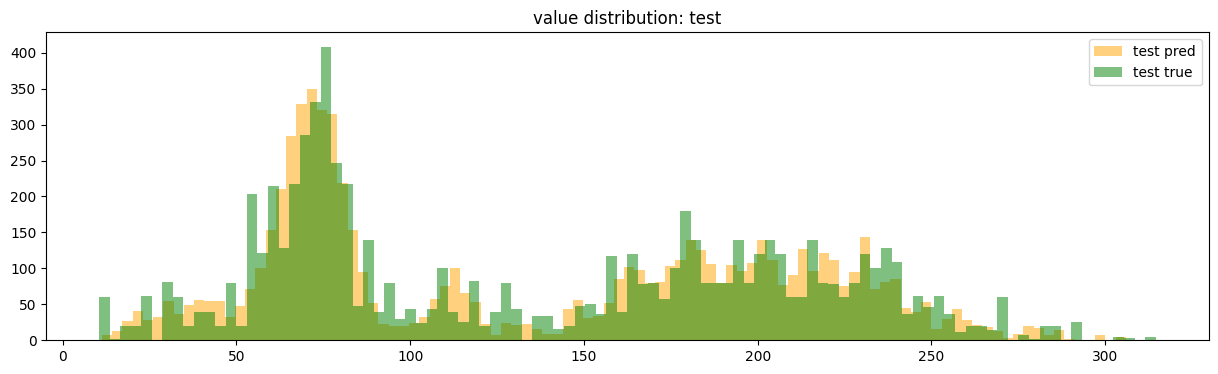

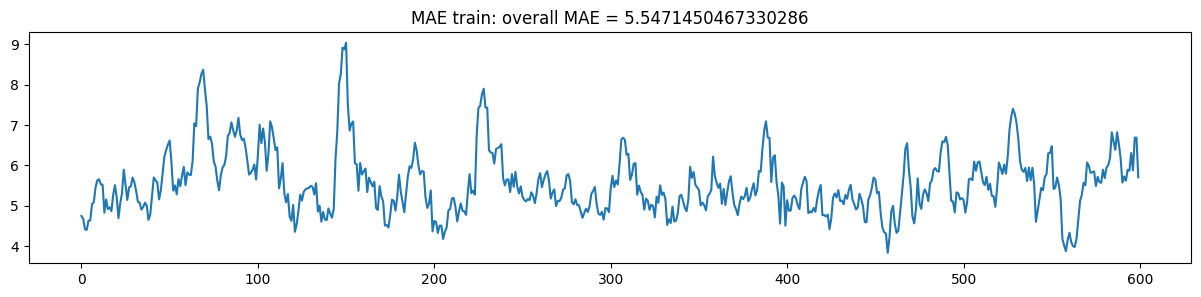

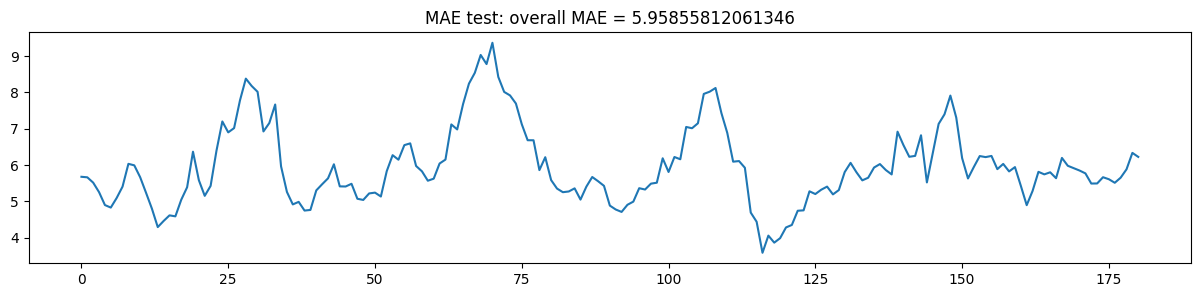

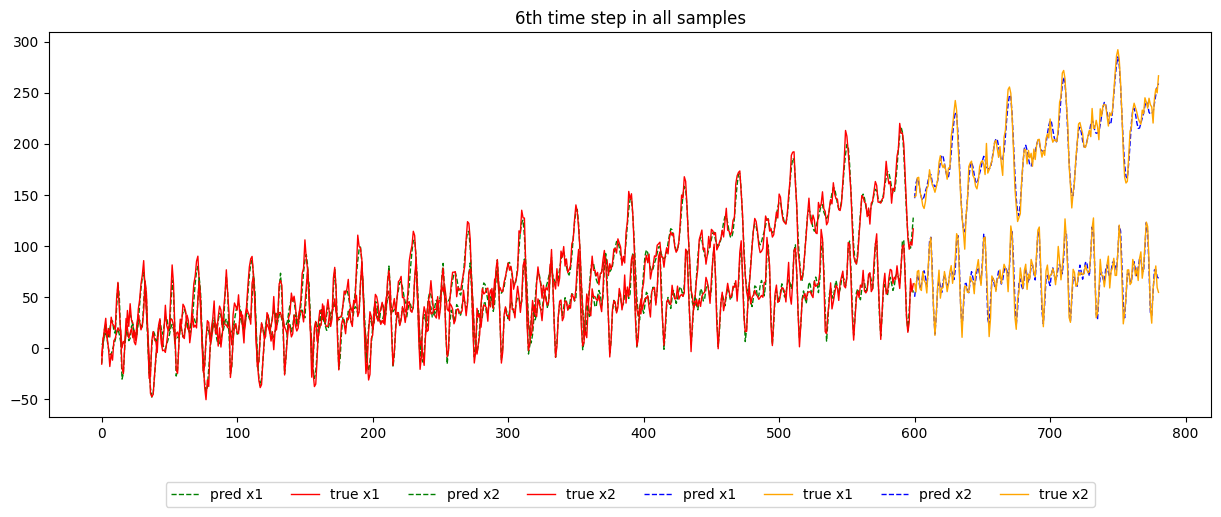

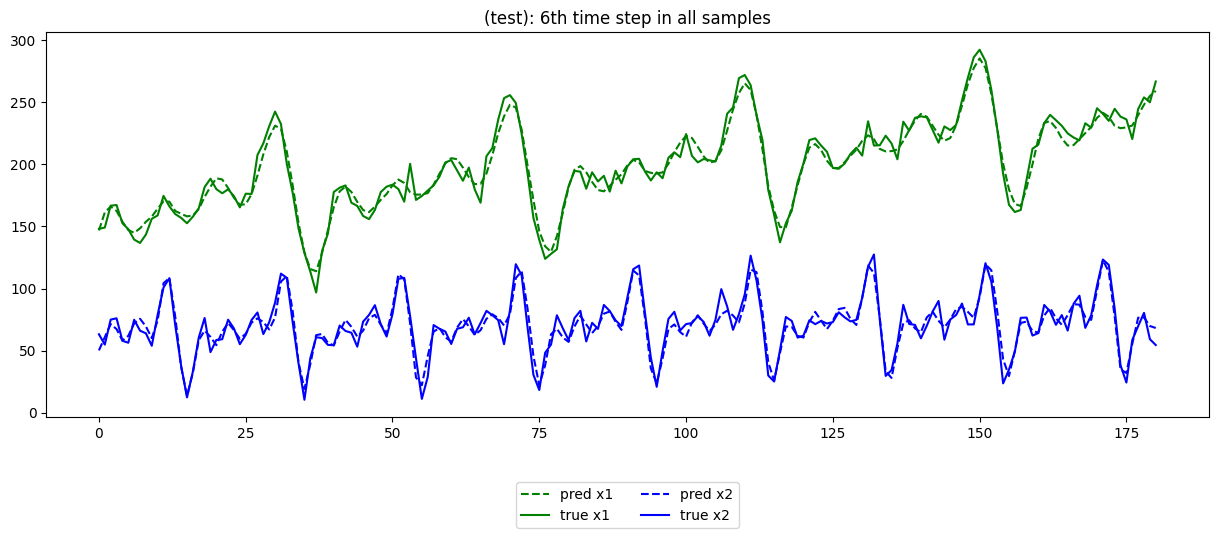

In [5]:
##-------------------------------------------------------------------##
##---- Model 2: Model 2: LSTM Seq2Seq Model with Luong Attention ----##
##-------------------------------------------------------------------##

# We will build Luong Attention on top of Model 1, and use  
# dot method to calculate alignment score, i.e., H_encoder.H_decoder

#---- The input layer: same as in Model 1
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

#---- The encoder LSTM: 
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
#return_sequences=True + return_state=True =>  All Hidden States + Last Hidden State + Last Cell State 

print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)
#Tensor("lstm_3/transpose_1:0", shape=(None, 200, 100), dtype=float32)
#Tensor("lstm_3/while:4", shape=(None, 100), dtype=float32)
#Tensor("lstm_3/while:5", shape=(None, 100), dtype=float32)

#---- The decoder LSTM: 
# We make 20 copies of the last hidden state of encoder & use them as input to the decoder
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)
#Tensor("repeat_vector_6/Tile:0", shape=(None, 20, 100), dtype=float32)

decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
  return_state=False, return_sequences=True)(
  decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)
#Tensor("lstm_6/transpose_1:0", shape=(None, 20, 100), dtype=float32)

#---- Attention Layer: 
# Calculate the alignment score, and apply softmax activation function
attention_score = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention_score)
print(attention)
#Tensor("activation/truediv:0", shape=(None, 20, 200), dtype=float32)

# Calculate the context vector, and apply batch normalisation
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)
#Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(None, 20, 100), dtype=float32)

# Concatenate the context vector and stacked hidden states of decoder, 
# and use it as input to the last dense layer
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)
#Tensor("concatenate/concat:0", shape=(None, 20, 200), dtype=float32)

out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)
#Tensor("time_distributed_2/Reshape_1:0", shape=(None, 20, 2), dtype=float32)

# Build the model and compile it
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

# Train the model
epoch = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epoch, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
#model.save('model_forecasting_seq2seq_Luong.h5')

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#---- Prediction:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
#(600, 20, 2) (181, 20, 2)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)
#(600, 20, 2) (181, 20, 2)

# Combine the unnormalised outputs with their corresponding index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
#(600, 20, 3) (181, 20, 3)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
#(600, 20, 3) (181, 20, 3)

# put all the outputs with recovered trend into a dictionary data_final
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))
#train_pred: (600, 20, 2)
#train_true: (600, 20, 2)
#test_pred: (181, 20, 2)
#test_true: (181, 20, 2)

# Check if the prediction value distribution is reasonable
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()
#The data distribution of prediction and true values are almost overlapped, so we are good.

# plot MAE of all samples in time order
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()
#We can say that there are still certain periodical pattens in both train and test MAE. 
#Training for more epochs may lead to better results.    
    
# check the nth prediction of each time step:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

# Take a closer look at the prediction on test set:    
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()    